In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, 
                                                  array_to_img, img_to_array, 
                                                  load_img) 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.image as mpimg
import pathlib
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, Xception, InceptionV3
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.utils import plot_model


from datetime import datetime
import datetime
import time
from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing import image 

In [2]:

def find_missclass_indx(real_labels, prediction_labels):
    incorrect_index = []
    for ind, (i, j) in enumerate(zip(real_labels, prediction_labels)):
      if i != j:
        print('True- {}, \nPred- {}\n'.format(i,j))
        incorrect_index.append(ind)
    return incorrect_index


def plot_missclass(holdout_generator, predictions, axs = 'ax'):
    x,y = holdout_generator.next()
    prediction_labels, real_labels = get_real_pred(predictions, holdout_generator)
    
    incorrect_index = find_missclass_indx(real_labels, prediction_labels)
    ax = axs.flatten()
    for i, ind in enumerate(incorrect_index):
        rl = real_labels[ind]
        pl = prediction_labels[ind]
        image = x[ind]
        ax[i].set_title('Actual: {}, \n Predicted: {}'.format(rl, pl))
        ax[i].imshow(image)
        ax[i].axis('off')



def show_imgs(direct, num_imgs=20):
    images = os.listdir(direct)[:num_imgs]
    plt.figure(figsize=(18,18))
    for i in range(num_imgs):
        #connect directory to selected breed path and image number
        img = mpimg.imread(direct + '/'+ images[i])
        plt.subplot(num_imgs/5+1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')


def plot_acc_loss_per_epoch(fit_model, epochs=10, file_name = 'train_acc_loss_basic.png'):
    acc = fit_model.history['accuracy']
    val_acc = fit_model.history['val_accuracy']
    top_k_acc = fit_model.history['top_k_categorical_accuracy']

    loss=fit_model.history['loss']
    val_loss=fit_model.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.plot(epochs_range, top_k_acc, label = 'Top 5 Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig(file_name)
    plt.show()



def create_data_gens(target_size = (229,229), train_dir = '../../images/Images/train', test_dir = '../../images/Images/test',  batch_size = 16):
    '''
    this is the augmentation configuration we will use for training
    PARAMS: train, val, holdout dirs are directories geared toward the storage of such data

    all images are resized to (229,229)

    RETURNS:
    each image generator in order train, val, holdout
   '''
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            train_dir, 
            shuffle=True, # this is the target directory
            target_size=target_size,  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical',
            seed = 42)  # since we use CategoricalCrossentropy loss, we need categorical labels

    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=target_size,
            batch_size=185,
            class_mode='categorical',
            shuffle = False,
            seed = 42)


    return train_generator, validation_generator

def basic_cnn(n_categs = 5):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_categs))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy', 'top_k_categorical_accuracy'])

    return model


def basic_transfer_model(input_size, n_categories, weights = 'imagenet', trans_model = VGG16):
    # note that the "top" is not included in the weights below
    base_model = trans_model(weights=weights,
                        include_top=False,
                        input_shape=input_size)
    model = base_model.output
    # add new head
    model = GlobalAveragePooling2D()(model)
    predictions = Dense(n_categories, activation='softmax')(model)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def create_new_transfer_model(input_size, n_categories, weights = 'imagenet', trans_model = Xception):
    # note that the "top" is not included in the weights below
    base_model = trans_model(weights=weights,
                        include_top=False,
                        input_shape=input_size)
    
    model = base_model.output

    model = GlobalAveragePooling2D()(model)
    model = Dropout(0.3)(model)
    model = Dense(500, activation='relu')(model)
    model = Dense(500, activation='relu')(model)

    output = Dense(n_categories, activation='softmax')(model)
    model = Model(inputs=base_model.input, outputs=output)
    return model


def print_model_properties(model, indices = 0):
     for i, layer in enumerate(model.layers[indices:]):
        print("Layer {} | Name: {} | Trainable: {}".format(i+indices, layer.name, layer.trainable))

def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True
        

def create_callbacks(file_path = "./../logs/", patience = 3):
    tensorboard = TensorBoard(log_dir= file_path+datetime.datetime.now().strftime("%m%d%Y%H%M%S"),
                                histogram_freq=0,
                                write_graph=False,
                                update_freq='epoch')
    early_stopping = EarlyStopping(restore_best_weights = True, patience = patience, monitor='val_loss')
    
    return tensorboard, early_stopping


def evaluate_model(model, holdout_generator):
    """
    evaluates model on holdout data
    params: model to evaluate
    Returns: [loss, accuracy]
        """

    metrics = model.evaluate(holdout_generator,
                                        use_multiprocessing=True,
                                        verbose=1)
    return metrics

def load_final_model(mod_file_path = "../models_and_weights/Xception_mod3_run2.h5", weights = '../models_and_weights/weights_Xception_mod3_run2' ):
    model = load_model(mod_file_path)
    model.load_weights(weights)
    return model



def get_preds(model, holdout_generator):
    pred = model.predict(holdout_generator,verbose=1)
    return pred

def get_real_pred(predictions, holdout_generator):
    predicted_class_indices = np.argmax(predictions,axis=1)
    labels = holdout_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    real_classes = holdout_generator.classes
    real_labels = [labels[k] for k in real_classes]
    predictions = ['-'.join(lab.split('-')[1:]) for lab in predictions]
    real_labels = ['-'.join(lab.split('-')[1:]) for lab in real_labels]
    return predictions, real_labels




In [3]:
train_generator, validation_generator = create_data_gens(target_size=(229,229), train_dir = "../images/Images/train",  test_dir = '../images/Images/test', batch_size = 30)

Found 4164 images belonging to 25 classes.
Found 185 images belonging to 25 classes.


In [4]:
model = load_model('models_and_weights/Xception_mod3_run2.h5')
model.load_weights('models_and_weights/weights_Xception_mod3_run2.h5')

In [5]:
pred = model.predict(validation_generator)

In [6]:
metrics = model.evaluate(validation_generator)

1/1 [==============================] - 38s 38s/step - loss: 0.1167 - accuracy: 0.9730 - top_k_categorical_accuracy: 0.9946


In [356]:
last_model = ([1.3926522731781006, 0.7777778, 0.9292929],[1.0582268238067627, 0.74418604, 0.95348835])
metrics

[0.1101246029138565, 0.972973, 0.99494946]

In [7]:
prediction_labels2, real_labels2 = get_real_pred(pred, validation_generator)

In [38]:
pred[0]

array([9.9980539e-01, 3.5087552e-13, 3.2599779e-08, 1.7876609e-07,
       1.0365282e-08, 5.3894894e-10, 2.5670913e-08, 4.6148497e-12,
       8.2158316e-09, 3.2542185e-12, 5.9303051e-10, 1.5386475e-05,
       8.2439999e-11, 1.7849822e-04, 4.6010860e-12, 7.2220040e-08,
       4.5183302e-11, 1.8438707e-13, 2.1796428e-12, 6.3931714e-11,
       5.5906985e-10, 3.1532430e-08, 4.0829997e-07, 5.5181187e-10,
       5.1837507e-11], dtype=float32)

True- Chihuahua, 
Pred- Pekinese

True- Blenheim_spaniel, 
Pred- whippet

True- papillon, 
Pred- Japanese_spaniel

True- Rhodesian_ridgeback, 
Pred- bloodhound

True- Boston_bull, 
Pred- pug



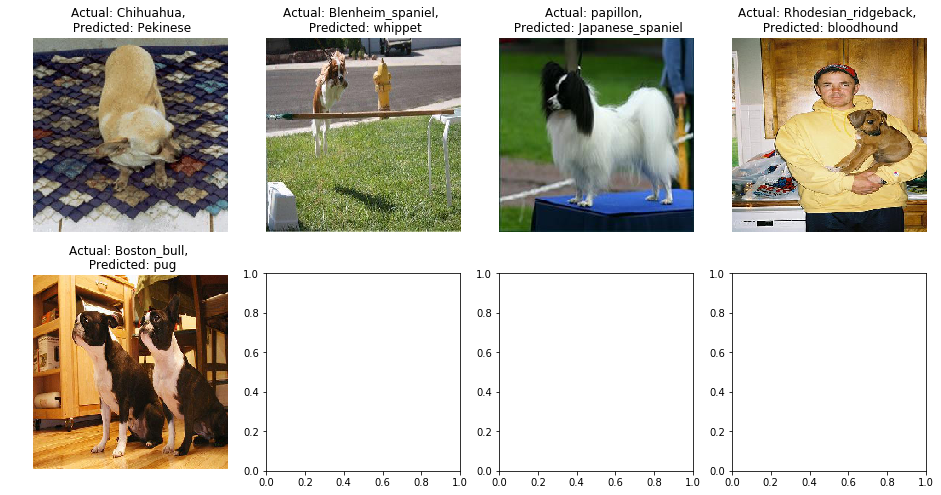

In [10]:
fig, axs = plt.subplots(2,4, figsize = (16,8))

plot_missclass(validation_generator, pred, axs = axs)

In [28]:
lst = ['MVIMG_20180623_100815.jpg',
       '57915eb192e6969679ffc599a569aefb.png', 
       '1c44f3b.jpg', 'IMG_6827.jpeg', 
       '9EA664D1-D73B-4FCD-BDEC-1CF112326EBE_1_105_c.jpeg',
      'image.png',
      'n02085620_275.jpg']

In [36]:
rees_dir = '../../../animal_images/'
img = lst[-1]
first_r_img = image.load_img(rees_dir+img, target_size = (229,229,3))
rees_img = image.img_to_array(first_r_img)
rees_img = np.expand_dims(rees_img,axis = 0)
rees_pred = model.predict(rees_img)

labels = validation_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
rees_pred

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [33]:

count = 0
for i in rees_pred[0]:
    if i != 0:
        count += 1
count

rees_indx = rees_pred[0].argsort()[::-1]

img_preds = []
for i in range(count):
    label = labels[rees_indx[i]]
    img_preds.append(('-'.join(label.split('-')[1:])))

Your Number 1 breed option is Rhodesian_ridgeback


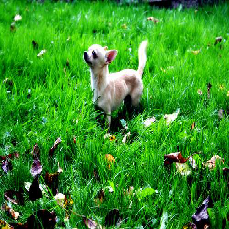

In [34]:
for i, im in enumerate(img_preds, 1):
    print('Your Number {} breed option is {}'.format(i, im))
first_r_img

In [31]:
rees_dir = '../../../animal_images/'
predicts = []
for pic in lst:
    img = pic
    first_r_img = image.load_img(rees_dir+img, target_size = (229,229))
    rees_img = image.img_to_array(first_r_img)
    rees_img = np.expand_dims(rees_img,axis = 0)
    rees_pred = model.predict(rees_img)
    predicts.append(rees_pred)

In [32]:
predicts

[array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]

In [365]:
d = {}
for i in train_generator.classes:
    if i not in d:
        d[i] = 1
    else:
        d[i] += 1

<BarContainer object of 25 artists>

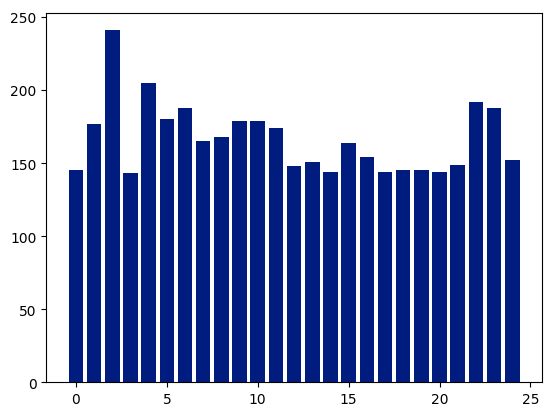

In [366]:
plt.bar(range(25), d.values())

In [367]:
train_generator.class_indices

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087394-Rhodesian_ridgeback': 7,
 'n02088238-basset': 8,
 'n02088466-bloodhound': 9,
 'n02091134-whippet': 10,
 'n02096585-Boston_bull': 11,
 'n02097209-standard_schnauzer': 12,
 'n02097298-Scotch_terrier': 13,
 'n02099601-golden_retriever': 14,
 'n02099712-Labrador_retriever': 15,
 'n02100735-English_setter': 16,
 'n02104029-kuvasz': 17,
 'n02106550-Rottweiler': 18,
 'n02106662-German_shepherd': 19,
 'n02107142-Doberman': 20,
 'n02109047-Great_Dane': 21,
 'n02110958-pug': 22,
 'n02112137-chow': 23,
 'n02113799-standard_poodle': 24}

In [368]:
labels = holdout_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
lst = list(labels.values())
real_labels = ['-'.join(lab.split('-')[1:]) for lab in lst]


In [369]:
from tensorflow.math import confusion_matrix
predicted_class_indices = np.argmax(pred2,axis=1)

real_classes = validation_generator.classes

conf_arry = confusion_matrix(real_classes, predicted_class_indices, num_classes=25)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [185] != values[1].shape = [86] [Op:Pack] name: stack

In [340]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-dark-palette')

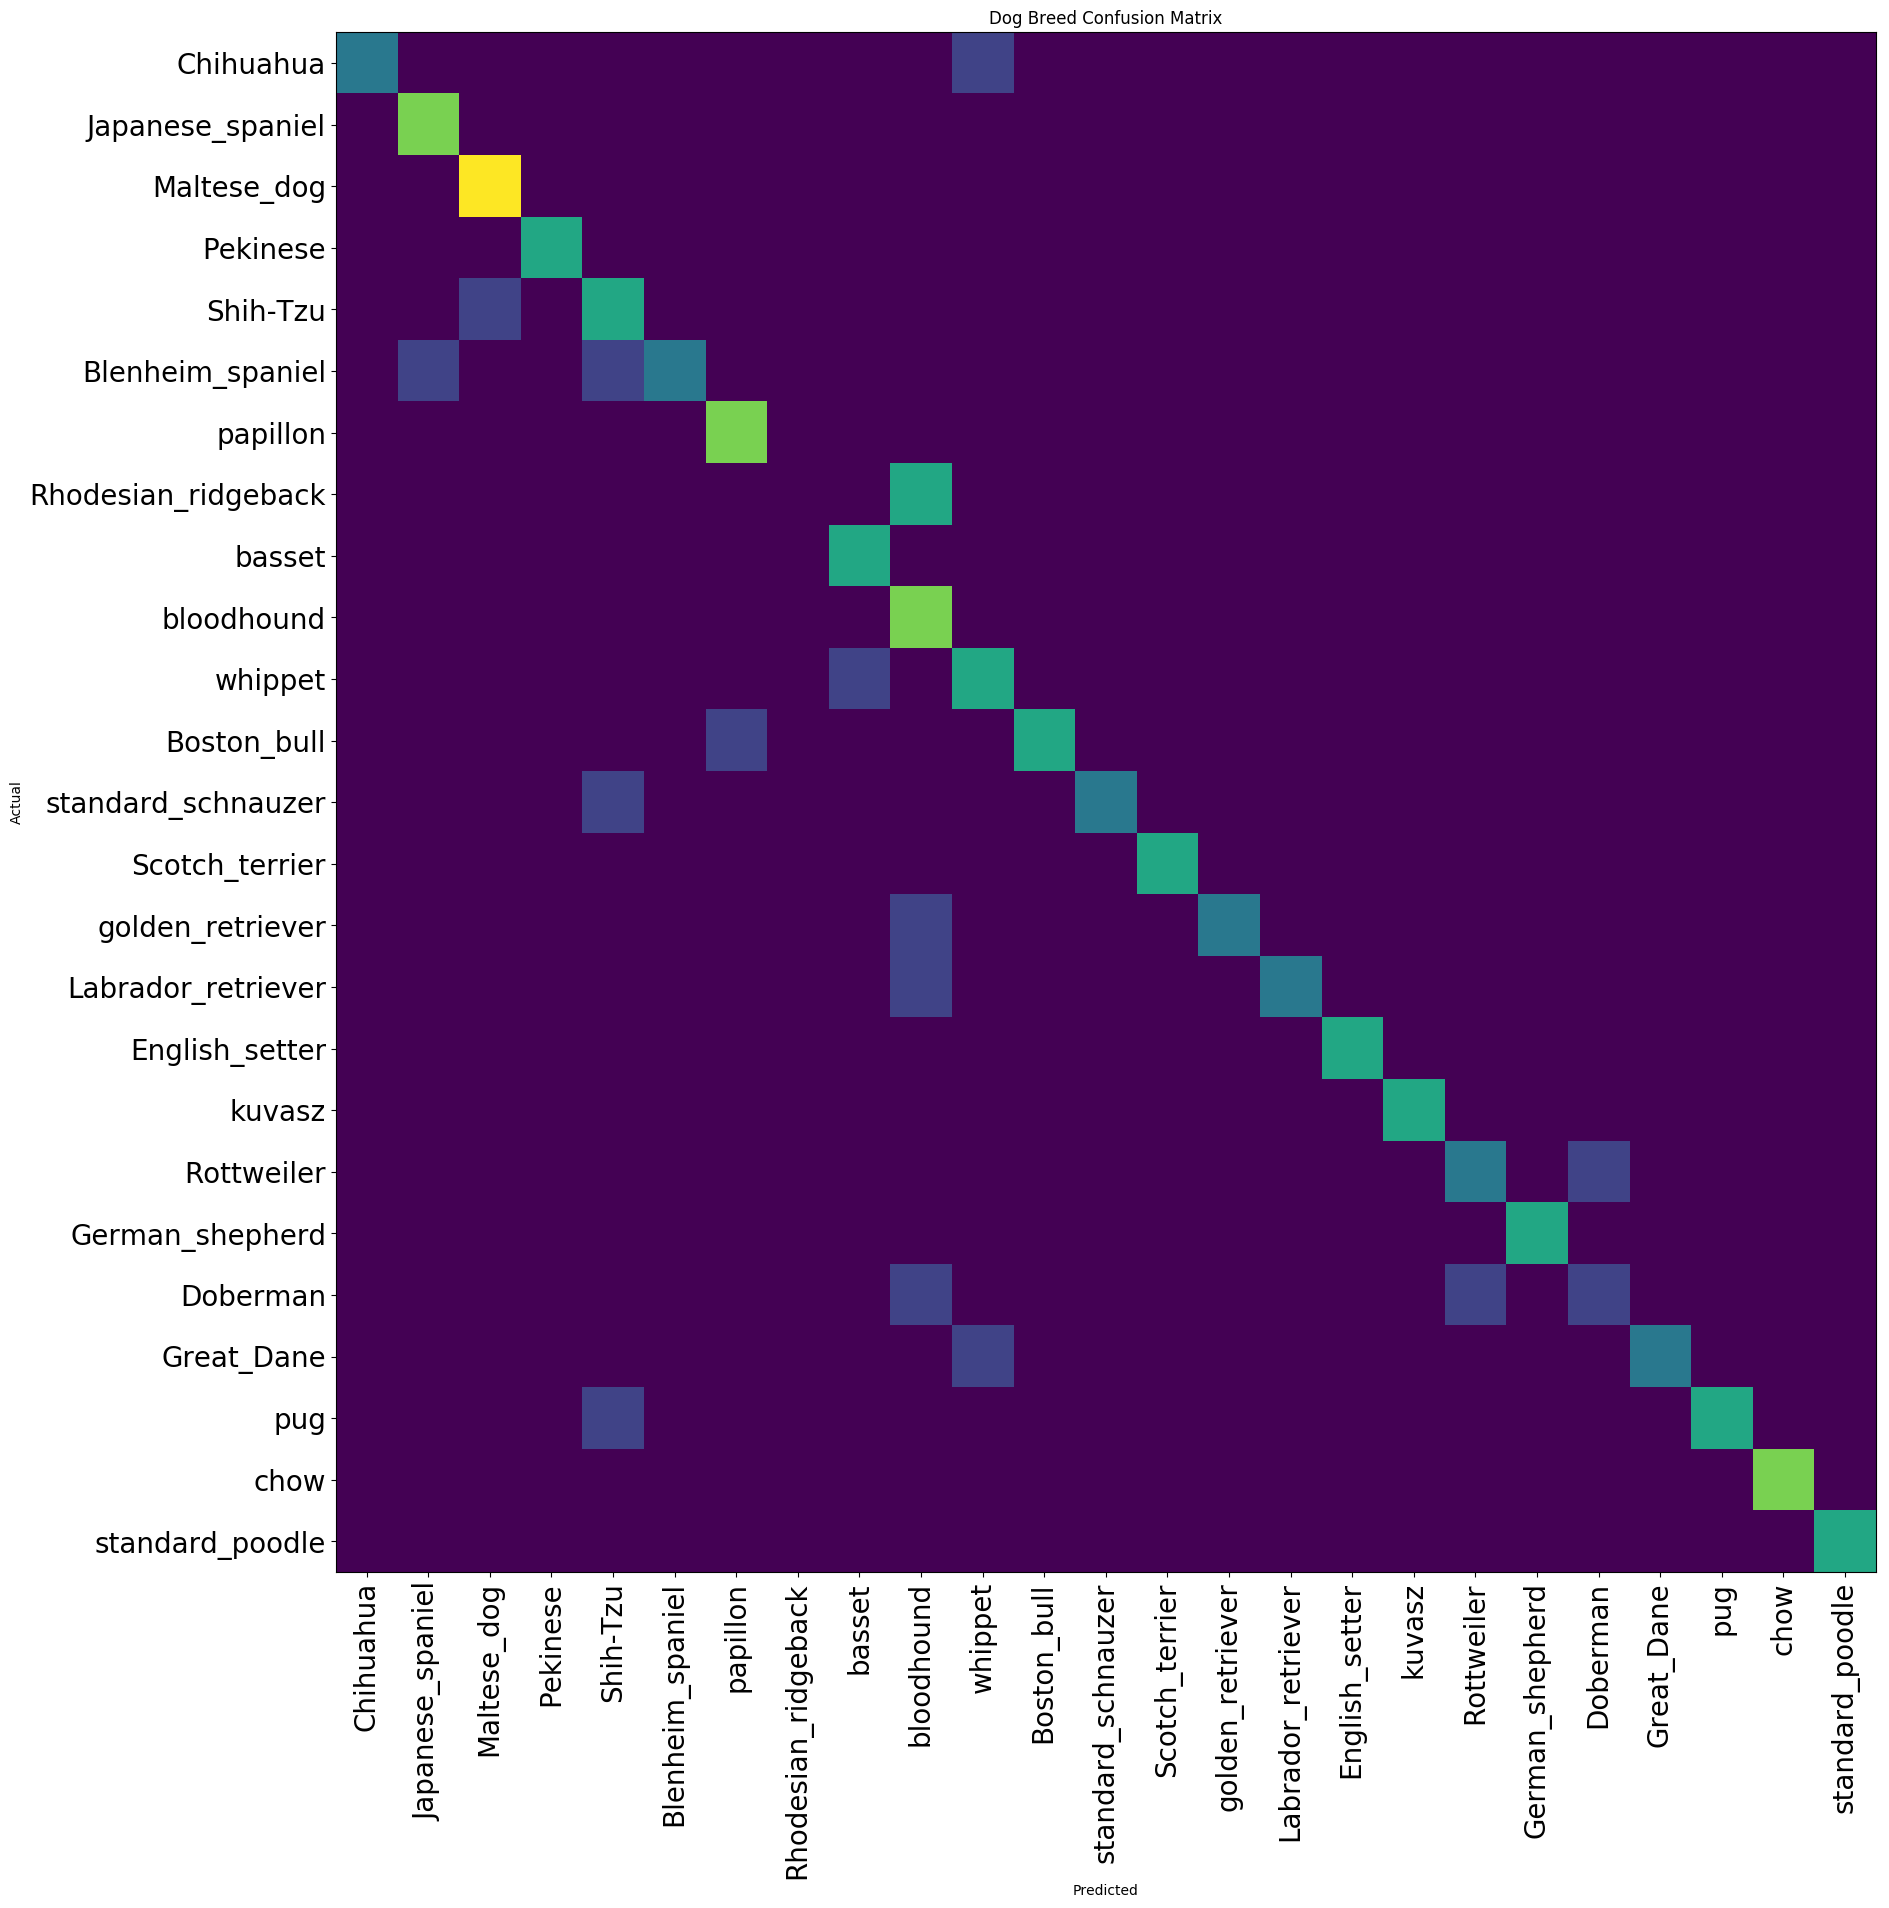

In [341]:
fig, ax = plt.subplots(1, figsize = (20,20))
ax.set_title('Dog Breed Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.imshow(conf_arry)
ax.set_xticks(range(25))
ax.set_yticks(range(25))
ax.set_xticklabels(real_labels, rotation=90, fontsize=20)
ax.set_yticklabels(real_labels, fontsize=20)
plt.show()

In [342]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import plot_confusion_matrix


In [343]:
import seaborn as sns

In [348]:
confusion_arr = cm(real_classes, predicted_class_indices)

In [349]:
df_cm = pd.DataFrame(confusion_arr, index = [i for i in real_labels],
              columns = [i for i in real_labels])

In [350]:
df_cm

,Chihuahua,Japanese_spaniel,Maltese_dog,Pekinese,Shih-Tzu,Blenheim_spaniel,papillon,Rhodesian_ridgeback,basset,bloodhound,...,Labrador_retriever,English_setter,kuvasz,Rottweiler,German_shepherd,Doberman,Great_Dane,pug,chow,standard_poodle
Chihuahua,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Japanese_spaniel,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Maltese_dog,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pekinese,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Shih-Tzu,0,0,1,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Blenheim_spaniel,0,1,0,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
papillon,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rhodesian_ridgeback,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
basset,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
bloodhound,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0


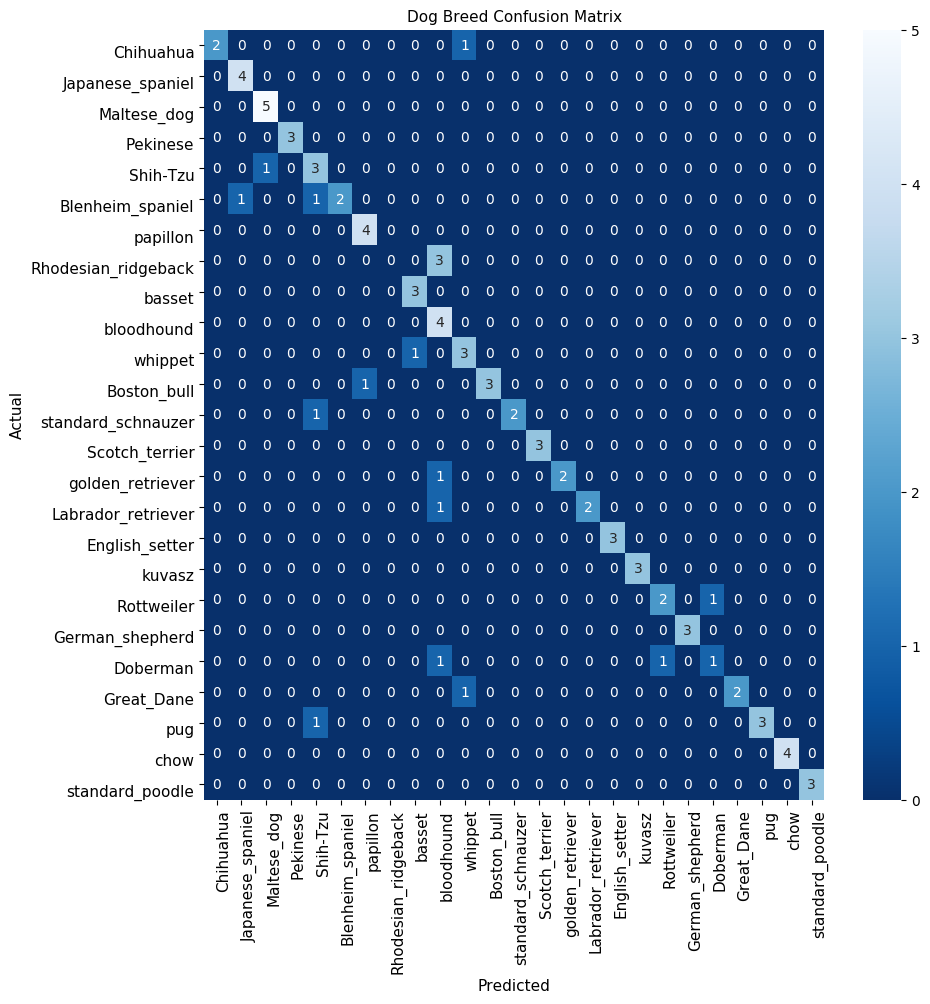

In [351]:
f_size = 11
fig, ax = plt.subplots(1, figsize = (10,10))
sns.heatmap(df_cm, annot=True,cmap="Blues_r", ax = ax)
ax.set_title('Dog Breed Confusion Matrix', fontsize=f_size)
ax.set_xlabel('Predicted', fontsize=f_size)
ax.set_ylabel('Actual', fontsize=f_size)
ax.set_xticklabels(real_labels, rotation=90, fontsize=f_size, ha='left')
ax.set_yticklabels(real_labels, fontsize=f_size, va = 'top')

plt.show()

In [ ]:
def plot_missclass(holdout_generator, predictions):
    x,y = holdout_generator.next()
    prediction_labels, real_labels = get_real_pred(predictions, holdout_generator)
    
    incorrect_index = find_missclass_indx(real_labels, prediction_labels)
    fig, axs = plt.subplots(4,2, figsize = (20,20))
    ax = axs.flatten()
    for i, ind in enumerate(incorrect_index):
        rl = real_labels[ind]
        pl = prediction_labels[ind]
        image = x[ind]
        ax[i].set_title('Actual: {}, \n Predicted: {}'.format(rl, pl))
        ax[i].imshow(image)
        ax[i].axis('off')